In [10]:
! pip install matplotlib jinja2

  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)


In [2]:
import os
import sys
import logging
from dotenv import load_dotenv

import dspy
from dspy.datasets.gsm8k import GSM8K, gsm8k_metric
from dspy.evaluate import Evaluate
from dspy.teleprompt import MIPROv2
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.getcwd()))
from mcts_llm.mctsr import MCTSr

load_dotenv()

logging.basicConfig(level=logging.WARNING)
logging.getLogger("mcts-llm").setLevel(logging.INFO)

np.random.seed(42)

/Users/yolo/miniconda/envs/mcts-llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
system_prompt = "The user will provide a problem. Solve the problem. Think step by step."
ollama = dspy.OllamaLocal(
    model="qwen2.5:1.5b-instruct", 
    model_type="chat",
    temperature=1.0,
    max_tokens=1024,
    num_ctx=1024,
    system=system_prompt,
    timeout_s=600
)
openai = dspy.OpenAI(
    model="deepseek-chat", 
    model_type="chat",
    api_key=os.environ["DEEPSEEK_API_KEY"], 
    base_url=os.environ["DEEPSEEK_BASE_URL"], 
    temperature=1.0,
    max_tokens=4096
)
dspy.settings.configure(lm=ollama, experimental=True)

In [4]:
gsm8k = GSM8K()

100%|██████████| 1319/1319 [00:00<00:00, 48842.88it/s]


In [5]:
gsm8k_trainset = [
    dspy.Example(
        problem=example['question'], 
        gold_reasoning=example['gold_reasoning'],
        answer=example['answer']
    ).with_inputs("problem") for example in gsm8k.train
]
np.random.shuffle(gsm8k_trainset)
gsm8k_trainset[:10]

[Example({'problem': 'A bowl of fruit holds 18 peaches. Four of the peaches are ripe and two more ripen every day, but on the third day three are eaten. How many more ripe peaches than unripe peaches are in the bowl after five days?', 'gold_reasoning': 'In 5 days, 2 * 5 = <<2*5=10>>10 peaches will ripen. With the 4 that were already ripe, there will be 14 peaches that have ripened. Three were eaten, so there will be 14 - 3 = <<14-3=11>>11 ripe peaches left. There are 18 - 14 = <<18-14=4>>4 unripe peaches left. Therefore, there will be 11 - 4 = <<11-4=7>>7 more ripe peaches than unripe peaches in the bowl after five days.', 'answer': '7'}) (input_keys={'problem'}),
 Example({'problem': 'John needs to replace his shoes so he decides to buy a $150 pair of Nikes and a $120 pair of work boots.  Tax is 10%.  How much did he pay for everything?', 'gold_reasoning': 'The shoes cost $150 + $120 = $<<150+120=270>>270 The tax was $270 * .1 = $<<270*.1=27>>27 So the total cost was $270 + $27 = $<<2

In [6]:
gsm8k_testset = [
    dspy.Example(
        problem=example['question'], 
        gold_reasoning=example['gold_reasoning'],
        answer=example['answer']
    ).with_inputs("problem") for example in gsm8k.test
]
np.random.shuffle(gsm8k_testset)
gsm8k_testset[:10]

[Example({'problem': "Great Grandma Jones has three children.  And each of her children has three children of their own, who are Great Grandma Jones' grandchildren.  And each of these grandchildren has three babies of their own, who are Great Grandma Jones' great grand-babies.  If all of the family show up at the family reunion, how many great grand-babies will be there for Great Grandma Jones to kiss?", 'gold_reasoning': 'Three children each have three children, for a total of 3*3=<<3*3=9>>9 grandchildren. 9 grandchildren each have 3 babies, for a total of 9*3=<<9*3=27>>27 great grand-babies', 'answer': '27'}) (input_keys={'problem'}),
 Example({'problem': 'Mark was unwell for 3 months, during which he lost 10 pounds per month. If his final weight was 70 pounds, what was his initial weight?', 'gold_reasoning': "Since Mark was losing 10 pounds each month, in 3 months he lost 10 * 3 = <<10*3=30>>30 pounds. Adding the weight lost to the final weight gives an initial weight of 70 + 30 = <

In [18]:
evaluate = Evaluate(
    devset=gsm8k_testset[:20], 
    metric=gsm8k_metric, 
    num_threads=os.cpu_count(), 
    display_progress=True,
    display_table=20,
)

In [8]:
optimizer = MIPROv2(
    prompt_model=openai,
    task_model=ollama,
    metric=gsm8k_metric,
    init_temperature=0.5,
    num_candidates=7,
    num_threads=os.cpu_count(),
    verbose=True
)
miprov2_mctsr = optimizer.compile(
    MCTSr(), 
    trainset=gsm8k_trainset[:50],
    requires_permission_to_run=False,
    num_trials=20,
    max_labeled_demos=0, 
    max_bootstrapped_demos=0
)
miprov2_mctsr.save("miprov2_mctsr.json")

Beginning MIPROv2 optimization process...

==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
These will be used for informing instruction proposal.

Bootstrapping N=7 sets of demonstrations...
Bootstrapping set 1/7
Bootstrapping set 2/7


 60%|██████    | 6/10 [06:45<04:30, 67.64s/it]


Bootstrapped 1 full traces after 7 examples in round 0.
Bootstrapping set 3/7


 90%|█████████ | 9/10 [11:12<01:14, 74.75s/it]


Bootstrapped 3 full traces after 10 examples in round 0.
Bootstrapping set 4/7


 50%|█████     | 5/10 [05:37<05:37, 67.43s/it]


Bootstrapped 2 full traces after 6 examples in round 0.
Bootstrapping set 5/7


 20%|██        | 2/10 [02:27<09:49, 73.70s/it]


Bootstrapped 1 full traces after 3 examples in round 0.
Bootstrapping set 6/7


 20%|██        | 2/10 [02:12<08:48, 66.01s/it]


Bootstrapped 1 full traces after 3 examples in round 0.
Bootstrapping set 7/7


 40%|████      | 4/10 [03:43<05:34, 55.81s/it]


Bootstrapped 1 full traces after 5 examples in round 0.

==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
In this step, by default we will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
SOURCE CODE: StringSignature(problem -> rationale, answer
    instructions='Given the fields `problem`, produce the fields `answer`.'
    problem = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Problem:', 'desc': '${problem}'})
    rationale = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${produce the output fields}. We ...', '__dspy_field_type': 'output'})
    answer = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'output', 'prefix': 'Answer:', 'desc': '${answer}'})
)

class ZeroShotCoT(dspy.Module):
    def __init__(self):
  

Average Metric: 9 / 40  (22.5): 100%|██████████| 40/40 [41:46<00:00, 62.67s/it] 
/Users/yolo/miniconda/envs/mcts-llm/lib/python3.12/site-packages/optuna/_experimental.py:30: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Default program score: 22.5

==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
In this step, we will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination. Bayesian Optimization will be used for this search process.

== Minibatch Trial 1 / 20 ==
Evaluating the following candidate program...

Predictor 0
i: Given the `problem`, provide a detailed step-by-step rationale explaining how to solve it, followed by the final `answer`. Ensure each step in the rationale is clear and logically connected to the next, leading to a coherent and accurate solution.
p: Answer:
Predictor 1
i: Given the fields `problem` and `current_answer`, critically evaluate the reasoning and accuracy of the `current_answer`, providing a detailed `critique` that either confirms the correctness of the answer or identifies any errors and suggests improvements.
p: Critique:
Predictor 2
i: Given a word problem and an answer, evaluate 

Average Metric: 5 / 25  (20.0): 100%|██████████| 25/25 [28:26<00:00, 68.28s/it]  


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:16<00:00, 136.41s/it]





Given the fields `problem`, `current_answer`, and `critique`, refine the `current_answer` based on the `critique` to produce a more accurate `answer`. Ensure the `rationale` explains the step-by-step reasoning used to arrive at the refined `answer`.

---

Follow the following format.

Problem: ${problem}

Current Answer: ${current_answer}

Critique: ${critique}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Answer: ${answer}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Current Answer:
Daisy's measurements should account for overcounted branches in the

Average Metric: 7 / 25  (28.0): 100%|██████████| 25/25 [38:55<00:00, 93.43s/it]   


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:43<00:00, 163.46s/it]





Given the fields `problem` and `answer`, provide a detailed `rationale` explaining the step-by-step reasoning used to arrive at the `answer`, and assign a `score` based on the accuracy and completeness of the reasoning.

---

Follow the following format.

Problem: ${problem}

Answer: ${answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Score: ${score}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Answer: Orders with names and quantities of the ordered products. This information is detailed according to how they were originally purchased, providing 

Average Metric: 5 / 25  (20.0): 100%|██████████| 25/25 [36:47<00:00, 88.28s/it]  


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:59<00:00, 179.33s/it]





Given the fields `problem` and `answer`, provide a detailed `rationale` explaining the step-by-step reasoning process used to arrive at the `answer`, and assign a `score` that reflects the correctness and accuracy of the `answer` based on the problem's requirements.

---

Follow the following format.

Problem: ${problem}

Answer: ${answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Score: ${score}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Answer: The correct average number of branches per foot, after refining our estimation through these consid

Average Metric: 3 / 25  (12.0): 100%|██████████| 25/25 [32:55<00:00, 79.01s/it]  


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [01:50<00:00, 110.83s/it]





Given the fields `problem`, `current_answer`, `critique`, produce the fields `rationale` and `answer` by addressing the critiques and providing a clear, step-by-step reasoning process to refine the answer.

---

Follow the following format.

Problem: ${problem}

Current Answer: ${current_answer}

Critique: ${critique}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Answer: ${answer}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Current Answer: Without the complete dataset of all four trees’ heights and branch counts as observed by Daisy, it is impossibl

Average Metric: 7 / 25  (28.0): 100%|██████████| 25/25 [30:34<00:00, 73.37s/it]  


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:20<00:00, 140.25s/it]





Given the fields `problem` and `answer`, evaluate the correctness and completeness of the `answer` by following a step-by-step reasoning process. Provide a detailed rationale explaining each step of the evaluation, and assign a score based on the accuracy and logical coherence of the `answer`. The score should reflect how well the `answer` addresses the problem, with higher scores indicating better performance.

---

Follow the following format.

Problem: ${problem}

Answer: ${answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Score: ${score}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many

Average Metric: 5 / 25  (20.0): 100%|██████████| 25/25 [30:45<00:00, 73.81s/it]  


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:27<00:00, 147.33s/it]





Given the fields `problem` and `answer`, provide a detailed `rationale` explaining the step-by-step reasoning used to arrive at the `answer`, and assign a `score` based on the accuracy and completeness of the reasoning.

---

Follow the following format.

Problem: ${problem}

Answer: ${answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Score: ${score}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Answer: 3.35 branches per foot

Please provide the output fields Reasoning then Score. Do so immediately, without additional content before or after, and 

Average Metric: 6 / 25  (24.0): 100%|██████████| 25/25 [29:04<00:00, 69.79s/it]  


Full trace of prompts in use on an example...


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [02:22<00:00, 142.36s/it]





Given the fields `problem`, `current_answer`, produce the fields `critique` by evaluating the reasoning steps and identifying any errors or inconsistencies in the current answer, and provide a detailed explanation of the correct approach if necessary.

---

Follow the following format.

Problem: ${problem}

Current Answer: ${current_answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Critique: ${critique}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Current Answer: 4

Please provide the output fields Reasoning then Critique. Do so immediately, with

Average Metric: 3 / 25  (12.0): 100%|██████████| 25/25 [28:18<00:00, 67.95s/it] 


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [01:45<00:00, 105.31s/it]





Given the fields `problem`, `current_answer`, and `critique`, refine the `current_answer` by addressing the issues highlighted in the `critique` and provide a detailed `rationale` explaining the steps taken to arrive at the new `answer`.

---

Follow the following format.

Problem: ${problem}

Current Answer: ${current_answer}

Critique: ${critique}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Answer: ${answer}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Current Answer:
The correct average of branches per foot from the given trees is 15 branches pe

Average Metric: 6 / 25  (24.0): 100%|██████████| 25/25 [36:29<00:00, 87.59s/it] 


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [03:16<00:00, 196.36s/it]





Given the fields `problem` and `answer`, provide a detailed `rationale` explaining the step-by-step reasoning used to arrive at the `answer`, and assign a `score` based on the accuracy and completeness of the reasoning.

---

Follow the following format.

Problem: ${problem}

Answer: ${answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Score: ${score}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Answer: The average number of branches per foot for the four trees is \(A_{avg} = 46.7125\).

Reasoning: Let's think step by step in order to
### Reasonin

Average Metric: 4 / 25  (16.0): 100%|██████████| 25/25 [27:37<00:00, 66.30s/it] 


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [01:59<00:00, 119.44s/it]





Given the fields `problem`, `current_answer`, produce the fields `critique`.

---

Follow the following format.

Problem: ${problem}

Current Answer: ${current_answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Critique: ${critique}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Current Answer: The approximate average number of branches per foot among these trees is 3 branches per foot, taking into consideration their specific heights and varying branching patterns within each neighborhood tree.

Please provide the output fields Reasoning then Criti

Average Metric: 8 / 40  (20.0): 100%|██████████| 40/40 [1:02:27<00:00, 93.69s/it] 


Full eval score: 20.0
Best full eval score so far: 22.5


== Minibatch Trial 11 / 20 ==
Evaluating the following candidate program...

Predictor 0
i: Given the `problem`, provide a detailed step-by-step rationale explaining how to solve it, followed by the final `answer`. Ensure the rationale clearly outlines the reasoning process and the answer is accurate based on the provided steps.
p: Answer:
Predictor 1
i: Given the fields `problem` and `current_answer`, produce a detailed `critique` that identifies any errors, ambiguities, or areas for improvement in the `current_answer`. The critique should include specific points of reasoning, highlighting both the strengths and weaknesses of the current answer, and suggest clear steps for refining the answer to better align with the problem's requirements.
p: Critique:
Predictor 2
i: Given the fields `problem`, `answer`, produce the fields `score`.
p: Score:
Predictor 3
i: Given the fields `problem`, `current_answer`, and `critique`, refine th

Average Metric: 0 / 25  (0.0): 100%|██████████| 25/25 [32:19<00:00, 77.60s/it] 


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:08<00:00, 128.91s/it]





Given the fields `problem`, `answer`, produce the fields `score`.

---

Follow the following format.

Problem: ${problem}

Answer: ${answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Score: ${score}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Answer: 2.46 branches per foot

Please provide the output fields Reasoning then Score. Do so immediately, without additional content before or after, and precisely as the format above shows. Begin with the field Reasoning.

Reasoning:
To find the average number of branches per foot, we first need to calcula

Average Metric: 2 / 25  (8.0): 100%|██████████| 25/25 [30:08<00:00, 72.33s/it] 


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:12<00:00, 132.65s/it]





Given the fields `problem` and `answer`, provide a detailed `rationale` explaining the step-by-step reasoning used to arrive at the `answer`, and assign a `score` based on the accuracy and completeness of the reasoning.

---

Follow the following format.

Problem: ${problem}

Answer: ${answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Score: ${score}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Answer: 3

Please provide the output fields Reasoning then Score. Do so immediately, without additional content before or after, and precisely as the form

Average Metric: 5 / 25  (20.0): 100%|██████████| 25/25 [30:19<00:00, 72.78s/it] 


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:24<00:00, 144.55s/it]





Given the fields `problem` and `answer`, evaluate the correctness and completeness of the `answer` by following a step-by-step reasoning process. Provide a detailed rationale explaining each step of the evaluation, and assign a score based on the accuracy and logical coherence of the `answer`. The score should reflect how well the `answer` addresses the problem, with higher scores indicating better performance.

---

Follow the following format.

Problem: ${problem}

Answer: ${answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Score: ${score}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many

Average Metric: 3 / 25  (12.0): 100%|██████████| 25/25 [37:13<00:00, 89.35s/it] 


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:48<00:00, 168.88s/it]





Given the fields `problem`, `current_answer`, and `critique`, refine the `current_answer` by addressing the issues highlighted in the `critique` and provide a detailed `rationale` explaining the steps taken to arrive at the new `answer`.

---

Follow the following format.

Problem: ${problem}

Current Answer: ${current_answer}

Critique: ${critique}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Answer: ${answer}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Current Answer:
The refined approach involves creating a detailed table showing the exact branc

Average Metric: 3 / 25  (12.0): 100%|██████████| 25/25 [31:53<00:00, 76.53s/it] 


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:59<00:00, 179.63s/it]





Given the fields `problem`, `current_answer`, produce the fields `critique` by evaluating the reasoning steps and identifying any errors or inconsistencies in the current answer, and provide a detailed explanation of the correct approach if necessary.

---

Follow the following format.

Problem: ${problem}

Current Answer: ${current_answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Critique: ${critique}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Current Answer: Daisy can observe that on average she observes 178.25 branches per foot across her c

Average Metric: 1 / 25  (4.0): 100%|██████████| 25/25 [32:54<00:00, 78.99s/it] 


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:20<00:00, 140.76s/it]





Given the fields `problem` and `current_answer`, provide a detailed `critique` that evaluates the current answer, identifies any potential errors or gaps in reasoning, and suggests improvements or corrections to arrive at a more accurate solution. Ensure the critique includes a step-by-step analysis of the problem to justify the proposed changes.

---

Follow the following format.

Problem: ${problem}

Current Answer: ${current_answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Critique: ${critique}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Cur

Average Metric: 4 / 25  (16.0): 100%|██████████| 25/25 [28:29<00:00, 68.38s/it] 


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:29<00:00, 149.06s/it]





Given a word problem and an answer, evaluate the correctness and completeness of the answer by providing a step-by-step rationale and a score between -100 and 100, where a higher score indicates a more accurate and well-reasoned answer.

---

Follow the following format.

Problem: ${problem}

Answer: ${answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Score: ${score}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Answer: 3

Please provide the output fields Reasoning then Score. Do so immediately, without additional content before or after, and prec

Average Metric: 4 / 25  (16.0): 100%|██████████| 25/25 [38:12<00:00, 91.69s/it] 


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:17<00:00, 137.71s/it]





Given the fields `problem`, `current_answer`, `critique`, produce the fields `answer`.

---

Follow the following format.

Problem: ${problem}

Current Answer: ${current_answer}

Critique: ${critique}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Answer: ${answer}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how many branches do these trees have per foot?

Current Answer:
The hypothetical calculated branches per foot ratio from proportional scaling is 713 branches / 184 feet = approximately **3.86** branches per foot for each given tree. Note that these are estimates and would greatly benefit from 

Average Metric: 5 / 25  (20.0): 100%|██████████| 25/25 [35:33<00:00, 85.33s/it] 


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:12<00:00, 132.63s/it]





Given the fields `problem` and `current_answer`, produce a detailed `critique` that identifies any errors, ambiguities, or areas for improvement in the `current_answer`. The critique should include specific points of reasoning, highlighting both the strengths and weaknesses of the current answer, and suggest clear steps for refining the answer to better align with the problem's requirements.

---

Follow the following format.

Problem: ${problem}

Current Answer: ${current_answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Critique: ${critique}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how ma

Average Metric: 3 / 25  (12.0): 100%|██████████| 25/25 [36:50<00:00, 88.41s/it]  


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [02:19<00:00, 139.53s/it]





Given the fields `problem` and `current_answer`, produce a detailed `critique` that identifies any errors, ambiguities, or areas for improvement in the `current_answer`. The critique should include specific points of reasoning, highlighting both the strengths and weaknesses of the current answer, and suggest clear steps for refining the answer to better align with the problem's requirements.

---

Follow the following format.

Problem: ${problem}

Current Answer: ${current_answer}

Reasoning: Let's think step by step in order to ${produce the output fields}. We ...

Critique: ${critique}

---

Problem: Daisy is climbing trees all around her neighborhood and starts to notice the number of branches and the height. The first tree she climbs is 50 feet tall and has 200 branches. The second tree she climbs is 40 feet tall and has 180 branches. The third tree she climbs is 60 feet tall and has 180 branches. The final tree she climbs is 34 feet tall and has 153 branches. On average, how ma

Average Metric: 8 / 40  (20.0): 100%|██████████| 40/40 [53:17<00:00, 79.93s/it]  

Full eval score: 20.0
Best full eval score so far: 22.5


[('zero_shot.cot', Predict(StringSignature(problem -> rationale, answer
    instructions='Given the fields `problem`, produce the fields `answer`.'
    problem = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Problem:', 'desc': '${problem}'})
    rationale = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${produce the output fields}. We ...', '__dspy_field_type': 'output'})
    answer = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'output', 'prefix': 'Answer:', 'desc': '${answer}'})
))), ('critique', Predict(StringSignature(problem, current_answer -> rationale, critique
    instructions='Given the fields `problem`, `current_answer`, produce the fields `critique`.'
    problem = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Probl

In [19]:
evaluate(miprov2_mctsr)

Average Metric: 5 / 20  (25.0): 100%|██████████| 20/20 [23:03<00:00, 69.16s/it]  


,problem,gold_reasoning,example_answer,pred_answer,gsm8k_metric
0,"Great Grandma Jones has three children. And each of her children has three children of their own, who are Great Grandma Jones' grandchildren. And each...","Three children each have three children, for a total of 3*3=<<3*3=9>>9 grandchildren. 9 grandchildren each have 3 babies, for a total of 9*3=<<9*3=27>>27 great grand-babies",27,45,
1,"Mark was unwell for 3 months, during which he lost 10 pounds per month. If his final weight was 70 pounds, what was his initial...","Since Mark was losing 10 pounds each month, in 3 months he lost 10 * 3 = <<10*3=30>>30 pounds. Adding the weight lost to the...",100,100 pounds,✔️ [True]
2,"On Tuesday, Peter wants to exercise for twice the amount of time he did on Monday and Sunday combined. On Sunday he exercised for 23...",On Sunday and Monday he exercised a total of 39 minutes because 23 + 16 = <<23+16=39>>39 On Tuesday he has to exercise for 78...,78,I don't know.,
3,"Abraham owns 80 square meters of unused land. He sold half of the land for $50, and after a month, he sold another 1/4 of...","Abraham sold 1/2 x 80= <<1/2*80=40>>40 square meters of his unused land. After a month, he sold 1/4 x 40 = <<1/4*40=10>>10 square meters of...",170,Abraham will earn a total of $120 from selling all his unused land.,
4,"A food caterer was told to prepare gourmet hot dogs for 36 guests. While most people would only eat one hotdog, he prepared enough for...","The food caterer prepared an additional 36/2 = <<36/2=18>>18 hot dogs. Altogether, he prepared 36 + 18 = <<36+18=54>>54 hotdogs. If 40 people wanted seconds,...",26,The answer to the problem is that 16 guests did not get a second hotdog.,
5,Bryce and four of his friends each ordered their own pizzas after football practice. Each pizza had 12 slices. Bryce and two friends ate 2/3...,"Bryce and his 4 friends each ordered a pizza with 12 slices, so there were 5 pizzas x 12 slices per pizza = <<5*12=60>>60 slices...",18,The problem does not contain enough information to determine exactly how much pizza is leftover.,
6,"Farmer Brown's farm is 200 acres, and Farmer Smith's farm is 100 acres more than twice that. How many acres do the two farms have,...",Farmer Smith has 2*200+100=<<2*200+100=500>>500 acres. The total is 200+500=<<200+500=700>>700.,700,The two farms together have **800 acres** in total.,
7,Charlie is a tennis pro. He spends most of the day teaching others lessons on how to improve their game. His standard fee is $80...,"4 1-hour lessons at his standard rate cost 4*$80=$<<4*80=320>>320. Reducing the rate by 25% for veterans means he takes $80/4=$<<80/4=20>>20 off his standard fee. Thus,...",440,Charlie will make a total of $440 for the day.,✔️ [True]
8,"Samwell owns an appliances store. For this week, one-fourth of their sales are smart TVs, one-eighth are analog TVs, and the rest are OLED TVs....","Samwell was able to sell 1/4 x 40 = <<1/4*40=10>>10 Smart TVs. He was able to sell 1/8 x 40 = <<1/8*40=5>>5 analog TVs. So,...",25,15,
9,"Arianna plants a garden that has 10 rows of flowers with 20 flowers in each row. Currently, only 4/5 of the planted flowers have bloomed....","Arianna planted 10 x 20 = <<10*20=200>>200 flowers in her garden. Out of the 200, 200 x 4/5 = <<200*4/5=160>>160 flowers that have currently bloomed.",160,The number of flowers that have bloomed in Arianna's garden is \( 160 \).,✔️ [True]


25.0

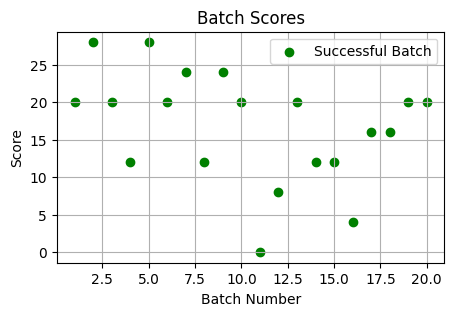

In [12]:
trial_logs = miprov2_mctsr.trial_logs
trial_numbers = list(trial_logs.keys())
scores = [trial_logs[trial]['score'] for trial in trial_numbers]
pruning_status = [trial_logs[trial]['pruned'] for trial in trial_numbers]

plt.figure(figsize=(5, 3))
for trial_number, score, pruned in zip(trial_numbers, scores, pruning_status):
    if pruned:
        plt.scatter(trial_number, score, color='grey', label='Pruned Batch' if 'Pruned Batch' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.scatter(trial_number, score, color='green', label='Successful Batch' if 'Successful Batch' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Batch Number')
plt.ylabel('Score')
plt.title('Batch Scores')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
best_score = 0

def get_signature(predictor):
    if (hasattr(predictor, 'extended_signature')):
        return predictor.extended_signature
    elif (hasattr(predictor, 'signature')):
        return predictor.signature

print(f"Baseline program | Score: {best_score}:")
for i,predictor in enumerate(MCTSr().predictors()):
    print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
print()

print("----------------")

for trial_num in miprov2_mctsr.trial_logs:
    program_score = miprov2_mctsr.trial_logs[trial_num]["score"]
    program_pruned = miprov2_mctsr.trial_logs[trial_num]["pruned"]
    best_score = program_score
    best_program_so_far = miprov2_mctsr.trial_logs[trial_num]["program"]
    print(f"Best program after {trial_num} batches | Score: {best_score}:")
    for i,predictor in enumerate(best_program_so_far.predictors()):
        print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
    print()

Baseline program | Score: 0:
Prompt 1 Instruction: Given the fields `problem`, produce the fields `answer`.
Prompt 2 Instruction: Given the fields `problem`, `current_answer`, produce the fields `critique`.
Prompt 3 Instruction: Given the fields `problem`, `answer`, produce the fields `score`.
Prompt 4 Instruction: Given the fields `problem`, `current_answer`, `critique`, produce the fields `answer`.

----------------
Best program after 1 batches | Score: 20.0:
Prompt 1 Instruction: Given the `problem`, provide a detailed step-by-step rationale explaining how to solve it, followed by the final `answer`. Ensure each step in the rationale is clear and logically connected to the next, leading to a coherent and accurate solution.
Prompt 2 Instruction: Given the fields `problem` and `current_answer`, critically evaluate the reasoning and accuracy of the `current_answer`, providing a detailed `critique` that either confirms the correctness of the answer or identifies any errors and suggests 